# Data Visualization of Great Lakes Environmental Data

In this notebook, we will explore various datasets related to the Great Lakes region, including ice concentration, sea surface temperature (GLSEA), bathymetry, and lake masks. We will visualize these datasets to better understand the patterns and distributions within each dataset, as well as the structure of the file formats that we will be using.

The key steps covered in this notebook include:
1. Loading data from both Zarr and NetCDF formats.
2. Preprocessing and standardizing the data for analysis using DeepSensor's DataProcessor class.
3. Performing basic sanity checks by visualizing different datasets.

Let's begin by importing the necessary packages and defining functions that will help us load and preprocess the data.


## Step 1: Import Packages and Define Helper Functions

To work with our datasets, we need to import several Python libraries:
- `xarray`: For working with multi-dimensional arrays (datasets).
- `matplotlib` and `cartopy`: For plotting and visualizing geographic data.
- `gcsfs`: For accessing Google Cloud Storage (GCS) to load remote data. (Not needed for U-M HPC)

We will also define a helper function called `standardize_dates`, which ensures that all time values in the datasets are converted to day-level precision (i.e., removing any time components and keeping only the date). (Eventually, this and other helper functions will be moved into the source code)


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import gcsfs
import os

In [2]:
def standardize_dates(ds):
    """
    Convert the 'time' dimension in an xarray dataset to date-only precision with datetime64[D].
    
    Parameters:
    ds (xarray.Dataset): The dataset whose 'time' dimension you wish to modify.
    
    Returns:
    xarray.Dataset: Modified dataset with time as datetime64[D].
    """
    if 'time' in ds.coords:
        # Convert time to day-level precision
        ds['time'] = ds['time'].dt.floor('D').values.astype('datetime64[D]')
    
    return ds

## Step 2: Load Environmental Data

In this section, we load several datasets from remote storage (Google Cloud Storage):
1. **Ice Concentration**: The percentage of ice cover in the Great Lakes.
2. **GLSEA**: Sea Surface Temperature (SST) for the Great Lakes.
3. **GLSEA3**: Another product covering SST data for the Great Lakes.

We will also load additional context data, including:
- **Bathymetry**: The depth of the lake bottom.
- **Lake Mask**: A binary mask indicating the presence of water in each grid cell.

Once the data is loaded, we preprocess it by handling missing values and standardizing the time dimension (if we don't do this, DeepSensor tends to throw errors related to not being able to find specific dates).


In [ ]:
# Path to the Zarr stores (NOTE: This won't work on U-M HPC. Paths must be changed)
ice_concentration_path = 'gs://great-lakes-osd/ice_concentration.zarr'
glsea_path = 'gs://great-lakes-osd/GLSEA_combined.zarr'
glsea3_path = 'gs://great-lakes-osd/GLSEA3_combined.zarr'

# Open the Zarr stores
ice_concentration = xr.open_zarr(ice_concentration_path)
glsea = xr.open_zarr(glsea_path)
glsea3 = xr.open_zarr(glsea3_path)

# Replace -1 (land value) with NaN
ice_concentration = ice_concentration.where(ice_concentration != -1, float('nan'))

# Convert all times to date-only format, removing the time component
ice_concentration = standardize_dates(ice_concentration)
glsea = standardize_dates(glsea)
glsea3 = standardize_dates(glsea3)

# Drop CRS - not needed
glsea = glsea.drop_vars('crs')
glsea3 = glsea3.drop_vars('crs')

In [4]:
# Set up GCS filesystem
fs = gcsfs.GCSFileSystem(project='great-lakes-osd')

# Path to the NetCDF files 
context_path = 'gs://great-lakes-osd/context/'

# Open the NetCDF files using xarray with gcsfs
bathymetry = xr.open_dataset(fs.open(os.path.join(context_path, 'interpolated_bathymetry.nc')))
lakemask = xr.open_dataset(fs.open(os.path.join(context_path, 'lakemask.nc')))

# Name the bathymetry variable (for some reason it's blank on loading)
bathymetry = bathymetry.rename({'__xarray_dataarray_variable__': 'bathymetry'})


## Step 3: Visualize Ice Concentration

We perform an initial sanity check to visualize the ice concentration data. This dataset represents the percentage of ice coverage in each grid cell.

We'll plot a specific time slice (e.g., a single time point) to get a snapshot of the ice concentration across the region.

First, have a look at the structure of our "ice concentration" xarray Dataset. Note the dimensions, coordinates, and the structure of the data variables. 

In [5]:
ice_concentration

<xarray.Dataset> Size: 155GB
Dimensions:            (time: 18434, lat: 1024, lon: 1024)
Coordinates:
  * lat                (lat) float64 8kB 50.6 50.59 50.58 ... 38.9 38.89 38.87
  * lon                (lon) float64 8kB -92.41 -92.39 -92.38 ... -75.89 -75.87
  * time               (time) datetime64[s] 147kB 1972-12-01 ... 2023-05-21
Data variables:
    ice_concentration  (time, lat, lon) float64 155GB dask.array<chunksize=(366, 200, 200), meta=np.ndarray>
Attributes: (12/23)
    coverage_area:            Great Lakes
    data_source:              NOAA
    description:              Great Lakes ice concentrations
    disclaimer:               Data collected and processed by NOAA and dissem...
    dissemination:            USNIC Website, CIS Website
    grid_resolution:          1.800 km
    ...                       ...
    product:                  GRID - Resolution 1800
    source:                   NAIS daily Great Lakes ice analysis
    source_url:               https://noaadata.apps.nsidc.org/NOAA/G10029/
    spatial_extent:           Lat: 38.87N to 50.6N, Lon: 92.41W to 75.87W
    time_range:               2009-01-01 to 2009-12-31
    units:                    Ice concentration (%)

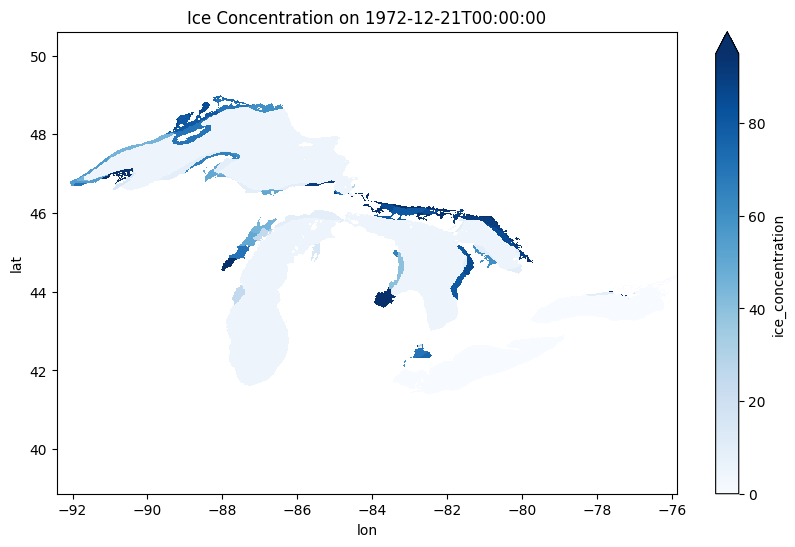

In [6]:
# Load the dataset
ds = ice_concentration

# Select a single time slice to plot, e.g., the first time point
time_index = 20
time_slice = ds.isel(time=time_index)

# Plotting
plt.figure(figsize=(10, 6))
ice_conc_plot = time_slice.ice_concentration.plot(
    x='lon', 
    y='lat', 
    cmap='Blues',
    robust=True  # Automatically exclude extreme outliers from color scaling
)
plt.title(f"Ice Concentration on {str(time_slice.time.values)}")
plt.show()

## Step 4: Visualize GLSEA (Sea Surface Temperature)

Next, we visualize the GLSEA dataset, which is a remote-sensing derived estimate of daily Sea Surface Temperature (SST) across the Great Lakes. This is important for understanding the thermal dynamics of the lakes, which can affect weather patterns, evaporation, and ecosystem health.

Let's visualize the SST for a specific day. As with ice concentration, first examine the structure of the xarray Dataset:


In [7]:
glsea

<xarray.Dataset> Size: 40GB
Dimensions:  (lat: 838, lon: 1181, time: 10221)
Coordinates:
  * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
  * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
  * time     (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
Data variables:
    sst      (time, lat, lon) float32 40GB dask.array<chunksize=(366, 200, 200), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.5
    GDAL:         GDAL 2.1.3, released 2017/20/01
    history:      Tue Feb 13 20:15:43 2024: cdo selyear,1995 GLSEA_SST_1995_2...
    source:       1995_001_glsea.asc
    title:        SST from Great Lakes Surface Environmental Analysis (GLSEA)

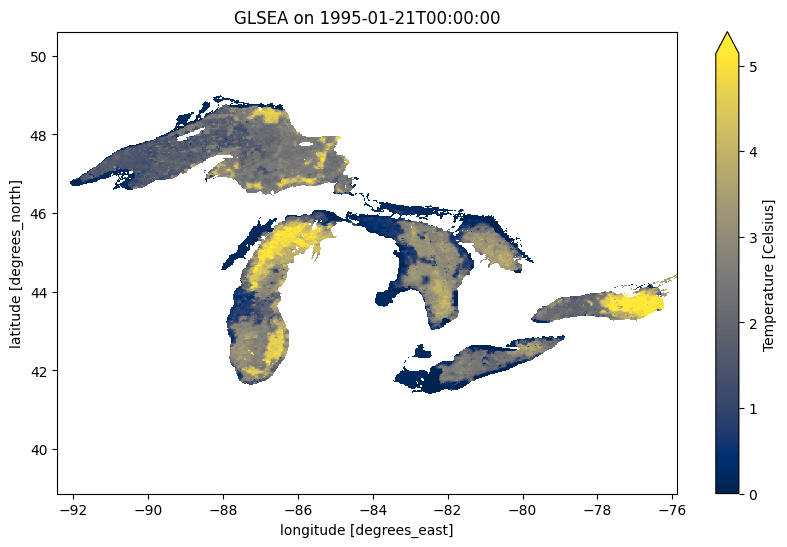

In [8]:
# Load the dataset
ds = glsea

# Select a single time slice to plot, e.g., the first time point
time_index = 20
time_slice = ds.isel(time=time_index)

# Plotting
plt.figure(figsize=(10, 6))
ice_conc_plot = time_slice.sst.plot(
    x='lon', 
    y='lat', 
    cmap='cividis',
    robust=True  # Automatically exclude extreme outliers from color scaling
)
plt.title(f"GLSEA on {str(time_slice.time.values)}")
plt.show()

## Step 5: Visualize Bathymetry Data

Bathymetry refers to the underwater topography of the Great Lakes, essentially mapping the depth of the lake bottom. This data is important for understanding how the lake’s physical characteristics affect water flow, sedimentation, and aquatic life.

Let's visualize the bathymetry dataset now, first by examining the xarray Dataset and second by making a quick plot.


In [9]:
bathymetry

<xarray.Dataset> Size: 696kB
Dimensions:     (lon: 360, lat: 240)
Coordinates:
  * lon         (lon) float64 3kB -92.07 -92.03 -91.98 ... -76.27 -76.23 -76.18
  * lat         (lat) float64 2kB 41.39 41.42 41.46 41.49 ... 48.73 48.76 48.79
Data variables:
    bathymetry  (lat, lon) float64 691kB ...

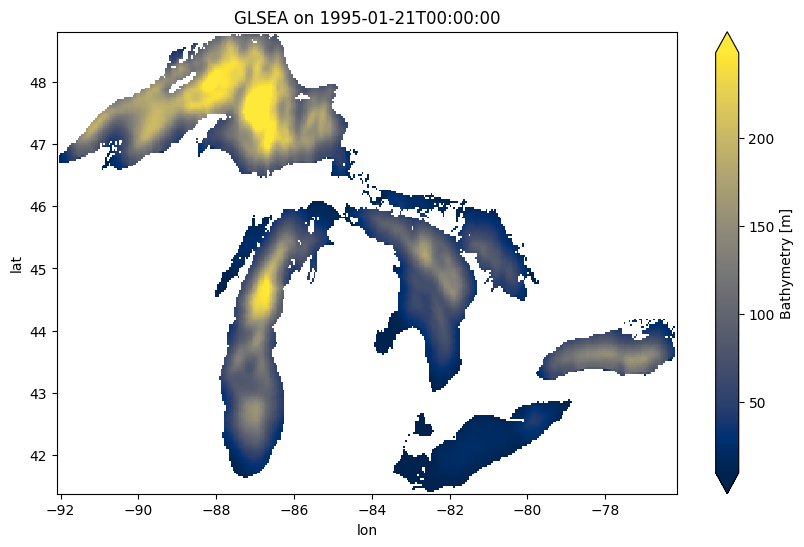

In [10]:
# Load the dataset
ds = bathymetry

# Plotting
plt.figure(figsize=(10, 6))
ice_conc_plot = ds.bathymetry.plot(
    x='lon', 
    y='lat', 
    cmap='cividis',
    robust=True  # Automatically exclude extreme outliers from color scaling
)
plt.title(f"GLSEA on {str(time_slice.time.values)}")
plt.show()

## Step 6: Visualize Lake Mask

The lake mask dataset indicates the presence of water in the Great Lakes region. It is simply a binary mask, where `1` represents water and `0` represents land.

We will plot the lake mask to make sure that it properly reflects the boundaries of the lakes and to verify the data's integrity.

Let's examine the lake mask xarray Dataset and plot it as well. 


In [11]:
lakemask

<xarray.Dataset> Size: 4MB
Dimensions:  (lon: 1181, lat: 838)
Coordinates:
  * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
  * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
Data variables:
    mask     (lat, lon) float32 4MB ...

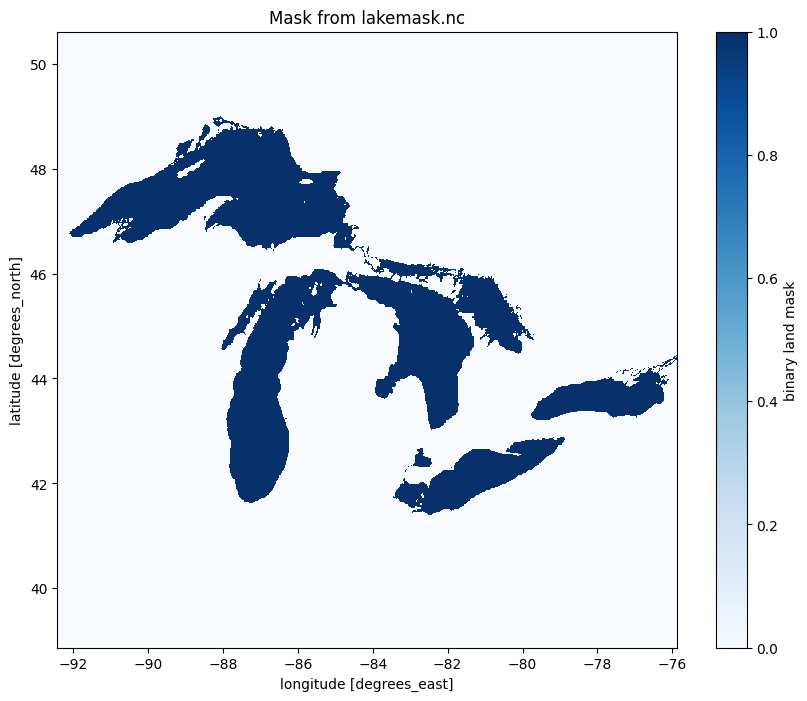

In [12]:
# Plot lakemask
lakemask_mask = lakemask['mask']

# Plot the data
plt.figure(figsize=(10, 8))
lakemask_mask.plot(cmap='Blues', add_colorbar=True)
plt.title('Mask from lakemask.nc')
plt.show()


# Conclusion

In this notebook, we successfully visualized several Great Lakes datasets, including ice concentration, sea surface temperature (GLSEA), bathymetry, and lake masks. By performing these sanity checks and visualizing the data, we've gained an initial understanding of the datasets' structures and contents.

In the next notebook, we will use DeepSensor's `DataProcessor` class for preprocessing. This will involve preparing the datasets for training. By the end of that notebook, we will be ready to train our model using the processed data.
